In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
import pickle
import pandas as pd
from suicide_data import SuicideDataset
from torch.utils.data import  DataLoader
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from utils import sketch,precision_recall_f1,accuracy_cal,map_to_labels
import copy
from model.attention_bilstm import BiLSTM_Attention
from model.lstm import SentimentLSTM
from model.rnn import SentimentRNN
from model.gru import GRU
from model.cnn import CNN

Load configuration,data,pretrained embeddings


In [4]:
# Load configuration file
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    lstm_config = config['LSTM']
    bilstm_config = config['BiLSTM_Attention']
    rnn_config = config['RNN']
    gru_config = config['GRU']
    cnn_config = config['CNN']

In [6]:
#Load training data
train_df = pd.read_csv("data/train_data.csv")
#Load validation data
val_df = pd.read_csv("data/val_data.csv")
#Load tokenizer object
with open("embeddings/tokenizer.json", "r") as f:
    tokenizer_json = json.load(f)
    tokenizer = tokenizer_from_json(tokenizer_json)
with open("embeddings/CBOW_embeddings.pkl" , "rb") as cbow:
    cbow_embeddings = pickle.load(cbow)
with open("embeddings/SkipGram_embeddings.pkl" , "rb") as sg:
    sg_embeddings = pickle.load(sg)

In [7]:
trainset = SuicideDataset(texts = train_df["cleaned_text"], labels = train_df["class"], tokenizer = tokenizer)
valset = SuicideDataset(val_df["cleaned_text"], val_df["class"], tokenizer)
train_loader = DataLoader(trainset, batch_size= 64,shuffle=True,drop_last=True)
val_loader = DataLoader(valset, batch_size=64, shuffle=True, drop_last=True)

In [8]:
VOCAB_SIZE=len(tokenizer.index_word)+1
# Load the pre-trained Word2Vec model (e.g., Google News vectors)
w2v_model = Word2Vec(sentences=common_texts, vector_size=300, window=5, min_count=1, workers=4)
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
#Creating thw embedding_matrix based on W2V model in gensim
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load model and Experimental results


Common train function for all model experiments

In [9]:
def train(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss().to(device)

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    train_f1s = []
    val_f1s = []

    # Track best metrics
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_metrics = []  # List to store all the best metrics in one place

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        total_train_f1 = 0

        # Training phase
        for step, (batch_embeddings, batch_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)

            tag_scores = model(batch_embeddings)
            loss = criterion(tag_scores, batch_labels.float())
            total_train_loss += loss.item()

            acc = accuracy_cal(tag_scores, batch_labels.float())
            total_train_acc += acc

            f1 = precision_recall_f1(tag_scores, batch_labels.float())[2]
            total_train_f1 += f1

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_acc / len(train_loader)
        avg_train_f1 = total_train_f1 / len(train_loader)

        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        total_val_f1 = 0

        with torch.no_grad():
            for batch_embeddings, batch_labels in val_loader:
                batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
                val_outputs = model(batch_embeddings)

                val_loss = criterion(val_outputs, batch_labels.float())
                total_val_loss += val_loss.item()

                val_acc = accuracy_cal(val_outputs, batch_labels.float())
                total_val_acc += val_acc

                val_f1 = precision_recall_f1(val_outputs, batch_labels.float())[2]
                total_val_f1 += val_f1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_acc / len(val_loader)
        avg_val_f1 = total_val_f1 / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

        # Update best metrics if current validation loss is better
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(model.state_dict())
            best_metrics = [
                best_epoch, avg_train_loss, best_val_loss,
                avg_train_acc, avg_val_acc,
                avg_train_f1, avg_val_f1
            ]

        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {avg_train_acc:.4f}%, Val Accuracy: {avg_val_acc:.4f}%, '
              f'Train F1-Score: {avg_train_f1:.4f}%, Val F1-Score: {avg_val_f1:.4f}%')

    # Load the best model state
    model.load_state_dict(best_model_state)
    print("\nTraining complete!")

    print(f"Best Model at Epoch {best_metrics[0]}: "
          f"Train Loss: {best_metrics[1]:.4f}, Val Loss: {best_metrics[2]:.4f}, "
          f"Train Accuracy: {best_metrics[3]:.4f}%, Val Accuracy: {best_metrics[4]:.4f}%, "
          f"Train F1-Score: {best_metrics[5]:.4f}%, Val F1-Score: {best_metrics[6]:.4f}%")

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s


# RNN

RNN without preprocessing model

Epoch [1/40], Train Loss: 0.6161, Val Loss: 0.5633, Train Accuracy: 0.6587%, Val Accuracy: 0.7251%, Train F1-Score: 0.5650%, Val F1-Score: 0.7468%
Epoch [2/40], Train Loss: 0.5767, Val Loss: 0.6239, Train Accuracy: 0.7037%, Val Accuracy: 0.6136%, Train F1-Score: 0.7093%, Val F1-Score: 0.7069%
Epoch [3/40], Train Loss: 0.5724, Val Loss: 0.5753, Train Accuracy: 0.7104%, Val Accuracy: 0.7037%, Train F1-Score: 0.7134%, Val F1-Score: 0.7433%
Epoch [4/40], Train Loss: 0.5627, Val Loss: 0.5472, Train Accuracy: 0.7196%, Val Accuracy: 0.7374%, Train F1-Score: 0.7210%, Val F1-Score: 0.7147%
Epoch [5/40], Train Loss: 0.5580, Val Loss: 0.5521, Train Accuracy: 0.7219%, Val Accuracy: 0.7040%, Train F1-Score: 0.7254%, Val F1-Score: 0.7549%
Epoch [6/40], Train Loss: 0.5193, Val Loss: 0.5040, Train Accuracy: 0.7585%, Val Accuracy: 0.7664%, Train F1-Score: 0.7629%, Val F1-Score: 0.7922%
Epoch [7/40], Train Loss: 0.4748, Val Loss: 0.4193, Train Accuracy: 0.7989%, Val Accuracy: 0.8412%, Train F1-Score: 0.

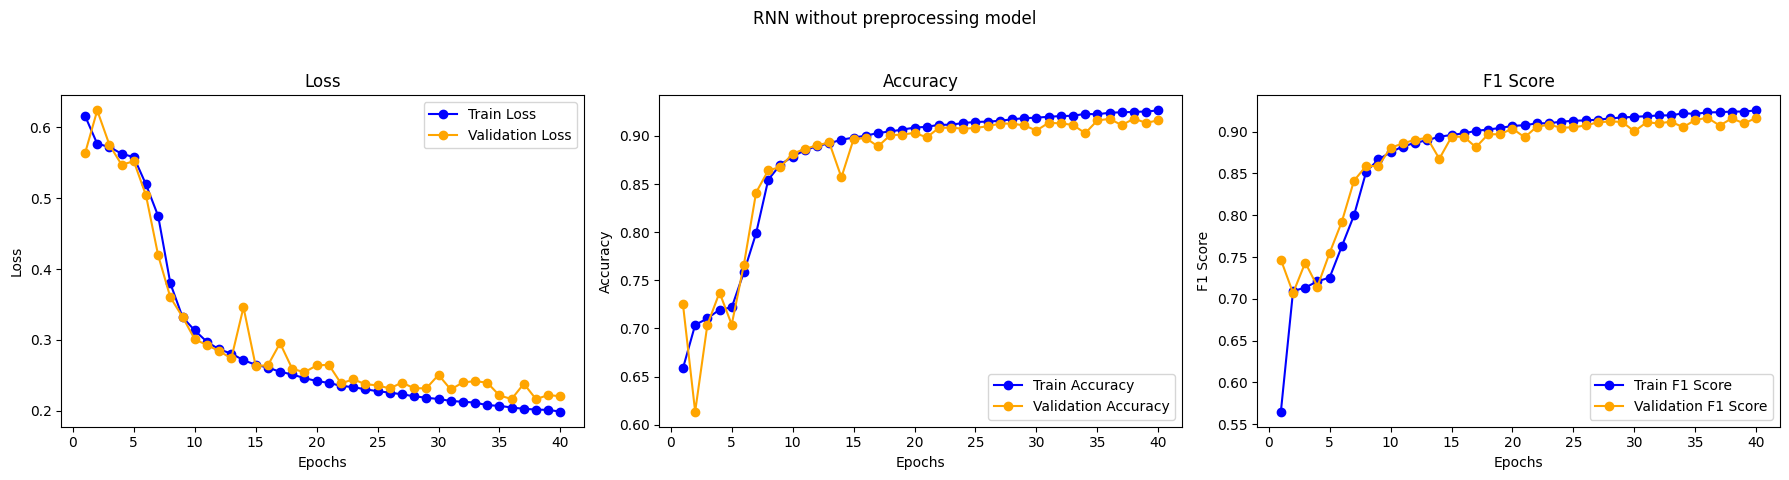

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config["epochs"],rnn_config["learning_rate"])
sketch("RNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with CBOW model

<ipython-input-1-76ae736803f5>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/40], Train Loss: 0.5208, Val Loss: 0.4623, Train Accuracy: 0.7426%, Val Accuracy: 0.7984%, Train F1-Score: 0.7253%, Val F1-Score: 0.7964%
Epoch [2/40], Train Loss: 0.4539, Val Loss: 0.4465, Train Accuracy: 0.8017%, Val Accuracy: 0.8046%, Train F1-Score: 0.7897%, Val F1-Score: 0.7886%
Epoch [3/40], Train Loss: 0.4443, Val Loss: 0.4373, Train Accuracy: 0.8060%, Val Accuracy: 0.8081%, Train F1-Score: 0.7939%, Val F1-Score: 0.8018%
Epoch [4/40], Train Loss: 0.4379, Val Loss: 0.4283, Train Accuracy: 0.8091%, Val Accuracy: 0.8118%, Train F1-Score: 0.7985%, Val F1-Score: 0.8010%
Epoch [5/40], Train Loss: 0.4291, Val Loss: 0.4163, Train Accuracy: 0.8129%, Val Accuracy: 0.8179%, Train F1-Score: 0.8028%, Val F1-Score: 0.8077%
Epoch [6/40], Train Loss: 0.4211, Val Loss: 0.4078, Train Accuracy: 0.8183%, Val Accuracy: 0.8227%, Train F1-Score: 0.8092%, Val F1-Score: 0.8081%
Epoch [7/40], Train Loss: 0.4085, Val Loss: 0.4487, Train Accuracy: 0.8254%, Val Accuracy: 0.8003%, Train F1-Score: 0.

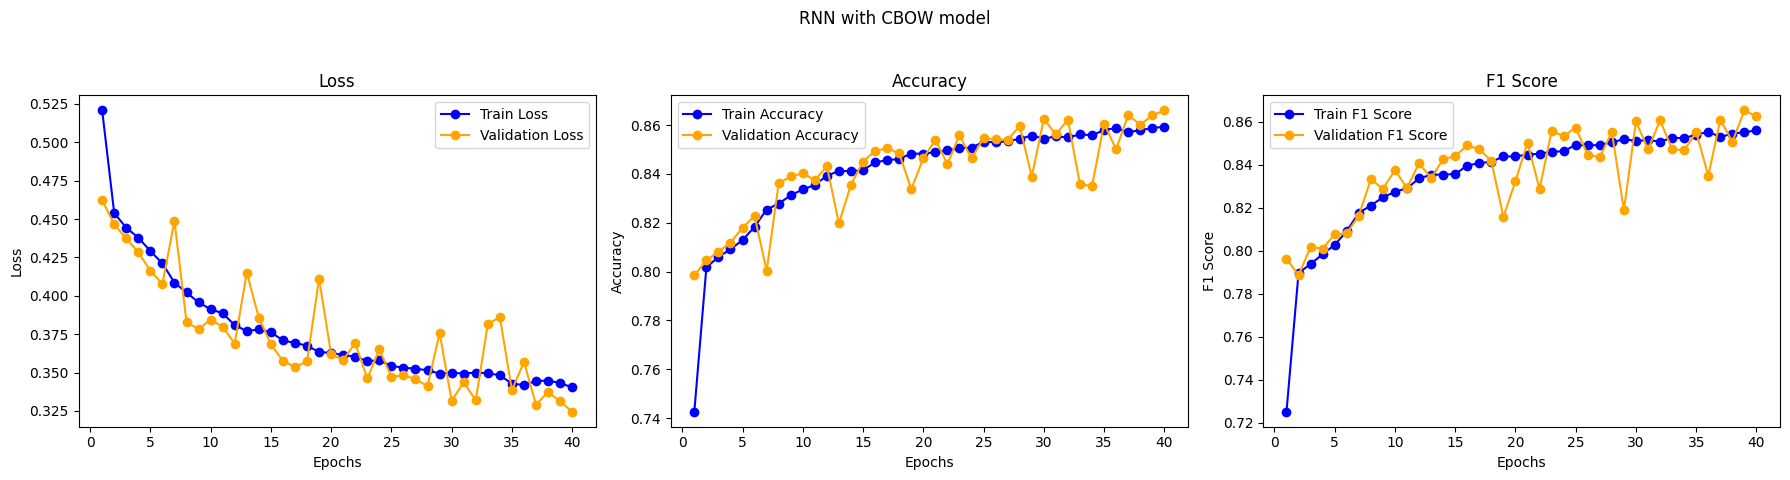

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config["epochs"],rnn_config["learning_rate"])
sketch("RNN with CBOW model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with Skip Gram model

<ipython-input-1-76ae736803f5>:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/40], Train Loss: 0.5759, Val Loss: 0.5391, Train Accuracy: 0.7051%, Val Accuracy: 0.7400%, Train F1-Score: 0.6587%, Val F1-Score: 0.7523%
Epoch [2/40], Train Loss: 0.5091, Val Loss: 0.4966, Train Accuracy: 0.7670%, Val Accuracy: 0.7714%, Train F1-Score: 0.7634%, Val F1-Score: 0.7817%
Epoch [3/40], Train Loss: 0.4780, Val Loss: 0.4658, Train Accuracy: 0.7886%, Val Accuracy: 0.7931%, Train F1-Score: 0.7832%, Val F1-Score: 0.7961%
Epoch [4/40], Train Loss: 0.4560, Val Loss: 0.4439, Train Accuracy: 0.8013%, Val Accuracy: 0.8076%, Train F1-Score: 0.7948%, Val F1-Score: 0.7979%
Epoch [5/40], Train Loss: 0.4378, Val Loss: 0.4281, Train Accuracy: 0.8105%, Val Accuracy: 0.8140%, Train F1-Score: 0.8037%, Val F1-Score: 0.7992%
Epoch [6/40], Train Loss: 0.4224, Val Loss: 0.4126, Train Accuracy: 0.8181%, Val Accuracy: 0.8246%, Train F1-Score: 0.8117%, Val F1-Score: 0.8152%
Epoch [7/40], Train Loss: 0.4088, Val Loss: 0.3935, Train Accuracy: 0.8252%, Val Accuracy: 0.8309%, Train F1-Score: 0.

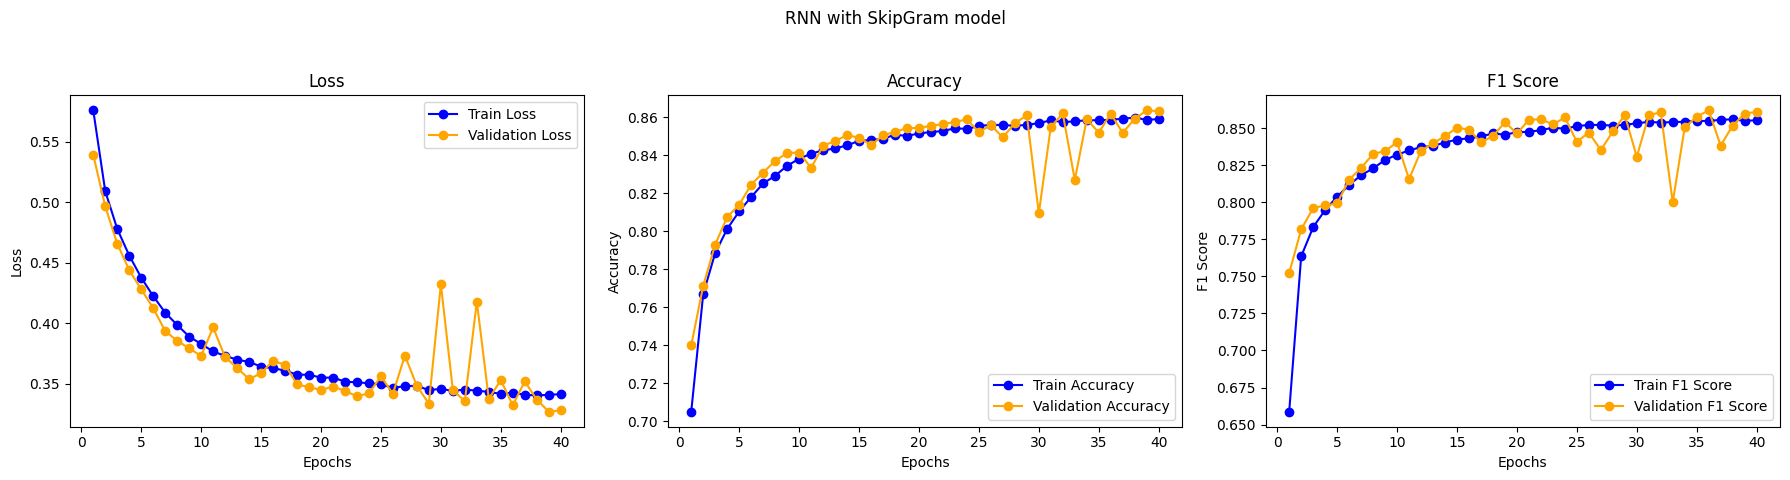

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings=  sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config["epochs"],rnn_config["learning_rate"])
sketch("RNN with SkipGram model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

RNN with pretrained W2V in Gensim

Epoch [1/40], Train Loss: 0.5846, Val Loss: 0.4852, Train Accuracy: 0.6820%, Val Accuracy: 0.7816%, Train F1-Score: 0.5974%, Val F1-Score: 0.7799%
Epoch [2/40], Train Loss: 0.4485, Val Loss: 0.4119, Train Accuracy: 0.8180%, Val Accuracy: 0.8465%, Train F1-Score: 0.8180%, Val F1-Score: 0.8410%
Epoch [3/40], Train Loss: 0.4091, Val Loss: 0.3927, Train Accuracy: 0.8495%, Val Accuracy: 0.8558%, Train F1-Score: 0.8444%, Val F1-Score: 0.8508%
Epoch [4/40], Train Loss: 0.3927, Val Loss: 0.3809, Train Accuracy: 0.8583%, Val Accuracy: 0.8633%, Train F1-Score: 0.8542%, Val F1-Score: 0.8628%
Epoch [5/40], Train Loss: 0.3813, Val Loss: 0.3957, Train Accuracy: 0.8641%, Val Accuracy: 0.8553%, Train F1-Score: 0.8599%, Val F1-Score: 0.8442%
Epoch [6/40], Train Loss: 0.3718, Val Loss: 0.3930, Train Accuracy: 0.8686%, Val Accuracy: 0.8637%, Train F1-Score: 0.8648%, Val F1-Score: 0.8675%
Epoch [7/40], Train Loss: 0.3655, Val Loss: 0.3559, Train Accuracy: 0.8714%, Val Accuracy: 0.8734%, Train F1-Score: 0.

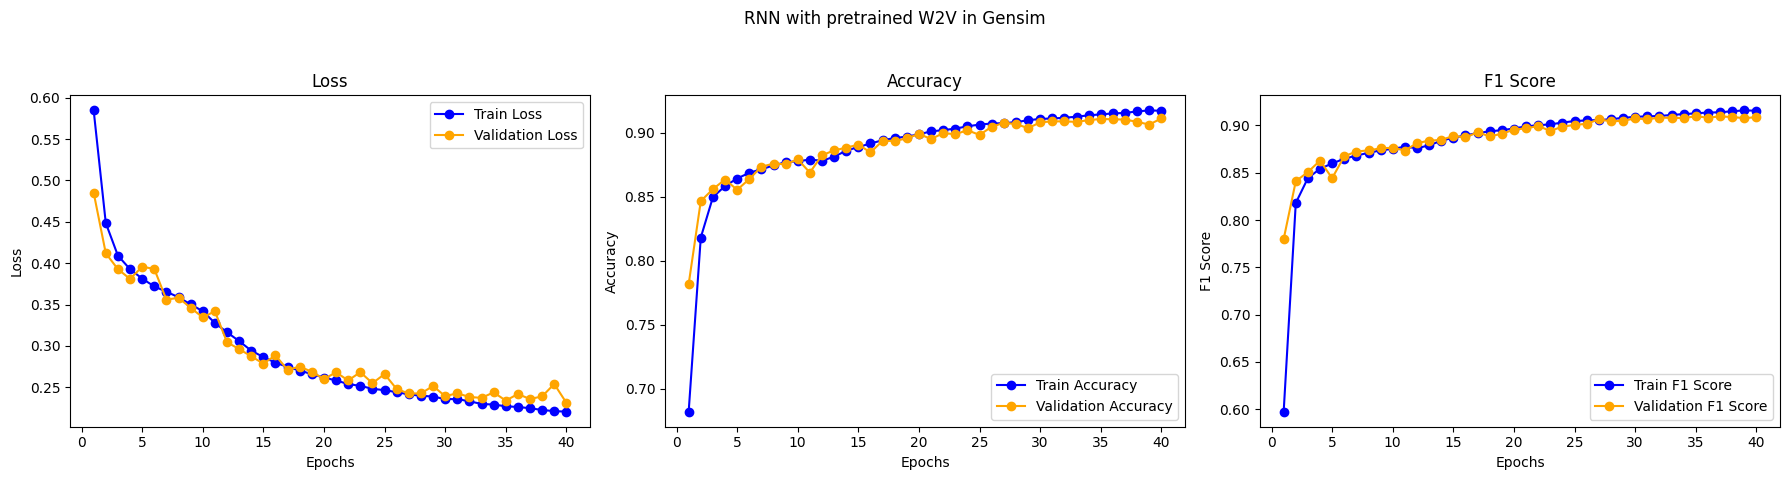

In [ ]:
model = SentimentRNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= rnn_config["embedding_dim"],
    hidden_size=rnn_config["hidden_size"],
    tagset_size=1,
    n_layers=rnn_config["num_layers"],
    dropout_rate=rnn_config['dropout_rate'],
    pretrained_embeddings = embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,rnn_config["epochs"],rnn_config["learning_rate"])
sketch("RNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# LSTM

LSTM without preprocessing model

Epoch [1/15], Train Loss: 0.2939, Val Loss: 0.2088, Train Accuracy: 0.8838%, Val Accuracy: 0.9204%, Train F1-Score: 0.8757%, Val F1-Score: 0.9207%
Epoch [2/15], Train Loss: 0.1962, Val Loss: 0.1925, Train Accuracy: 0.9291%, Val Accuracy: 0.9269%, Train F1-Score: 0.9279%, Val F1-Score: 0.9255%
Epoch [3/15], Train Loss: 0.1705, Val Loss: 0.1918, Train Accuracy: 0.9389%, Val Accuracy: 0.9280%, Train F1-Score: 0.9382%, Val F1-Score: 0.9262%
Epoch [4/15], Train Loss: 0.1488, Val Loss: 0.1937, Train Accuracy: 0.9472%, Val Accuracy: 0.9276%, Train F1-Score: 0.9464%, Val F1-Score: 0.9276%
Epoch [5/15], Train Loss: 0.1308, Val Loss: 0.1988, Train Accuracy: 0.9544%, Val Accuracy: 0.9274%, Train F1-Score: 0.9538%, Val F1-Score: 0.9274%
Epoch [6/15], Train Loss: 0.1148, Val Loss: 0.2112, Train Accuracy: 0.9601%, Val Accuracy: 0.9256%, Train F1-Score: 0.9596%, Val F1-Score: 0.9252%
Epoch [7/15], Train Loss: 0.0992, Val Loss: 0.2274, Train Accuracy: 0.9662%, Val Accuracy: 0.9257%, Train F1-Score: 0.

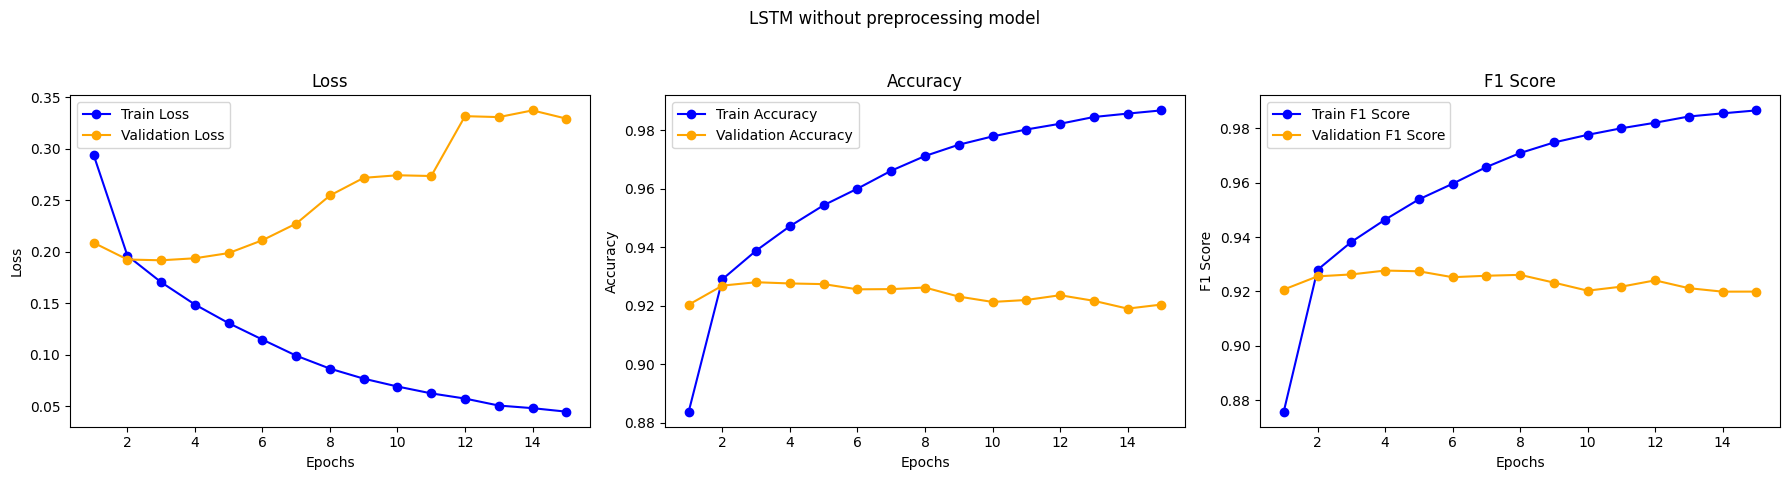

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,lstm_config['epochs'],lstm_config['learning_rate'])
sketch("LSTM without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with CBOW

<ipython-input-1-2e870bfeba3e>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/30], Train Loss: 0.4897, Val Loss: 0.4358, Train Accuracy: 0.7741%, Val Accuracy: 0.8097%, Train F1-Score: 0.7666%, Val F1-Score: 0.7937%
Epoch [2/30], Train Loss: 0.4045, Val Loss: 0.4203, Train Accuracy: 0.8293%, Val Accuracy: 0.8256%, Train F1-Score: 0.8218%, Val F1-Score: 0.8028%
Epoch [3/30], Train Loss: 0.3430, Val Loss: 0.3063, Train Accuracy: 0.8672%, Val Accuracy: 0.8802%, Train F1-Score: 0.8627%, Val F1-Score: 0.8788%
Epoch [4/30], Train Loss: 0.3123, Val Loss: 0.3026, Train Accuracy: 0.8816%, Val Accuracy: 0.8779%, Train F1-Score: 0.8778%, Val F1-Score: 0.8708%
Epoch [5/30], Train Loss: 0.2945, Val Loss: 0.2799, Train Accuracy: 0.8881%, Val Accuracy: 0.8888%, Train F1-Score: 0.8844%, Val F1-Score: 0.8831%
Epoch [6/30], Train Loss: 0.2818, Val Loss: 0.2662, Train Accuracy: 0.8941%, Val Accuracy: 0.8960%, Train F1-Score: 0.8908%, Val F1-Score: 0.8941%
Epoch [7/30], Train Loss: 0.2734, Val Loss: 0.2598, Train Accuracy: 0.8962%, Val Accuracy: 0.8979%, Train F1-Score: 0.

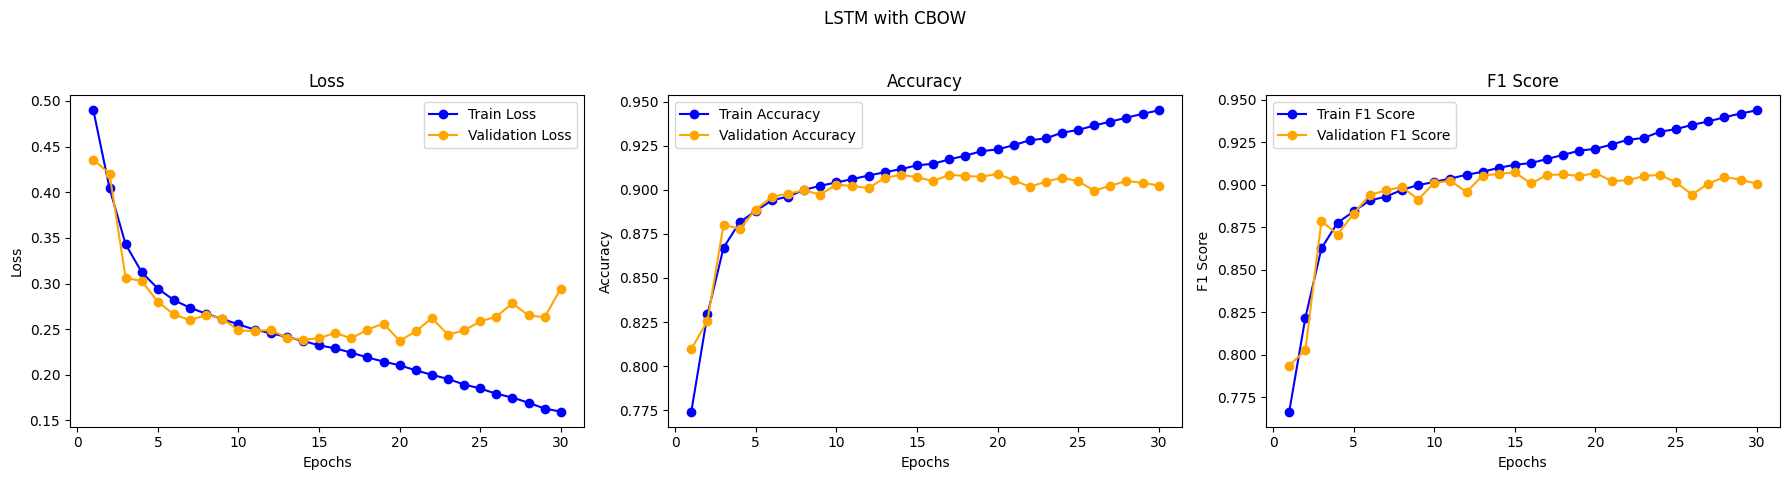

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,30,lstm_config['learning_rate'])
sketch("LSTM with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with SKipGram

<ipython-input-1-2e870bfeba3e>:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/30], Train Loss: 0.4864, Val Loss: 0.3889, Train Accuracy: 0.7730%, Val Accuracy: 0.8349%, Train F1-Score: 0.7598%, Val F1-Score: 0.8314%
Epoch [2/30], Train Loss: 0.3796, Val Loss: 0.3308, Train Accuracy: 0.8430%, Val Accuracy: 0.8625%, Train F1-Score: 0.8373%, Val F1-Score: 0.8562%
Epoch [3/30], Train Loss: 0.3328, Val Loss: 0.3026, Train Accuracy: 0.8665%, Val Accuracy: 0.8760%, Train F1-Score: 0.8621%, Val F1-Score: 0.8718%
Epoch [4/30], Train Loss: 0.3054, Val Loss: 0.2810, Train Accuracy: 0.8800%, Val Accuracy: 0.8879%, Train F1-Score: 0.8765%, Val F1-Score: 0.8858%
Epoch [5/30], Train Loss: 0.2865, Val Loss: 0.2879, Train Accuracy: 0.8887%, Val Accuracy: 0.8823%, Train F1-Score: 0.8861%, Val F1-Score: 0.8857%
Epoch [6/30], Train Loss: 0.2741, Val Loss: 0.2763, Train Accuracy: 0.8948%, Val Accuracy: 0.8950%, Train F1-Score: 0.8921%, Val F1-Score: 0.8965%
Epoch [7/30], Train Loss: 0.2624, Val Loss: 0.2651, Train Accuracy: 0.9002%, Val Accuracy: 0.8960%, Train F1-Score: 0.

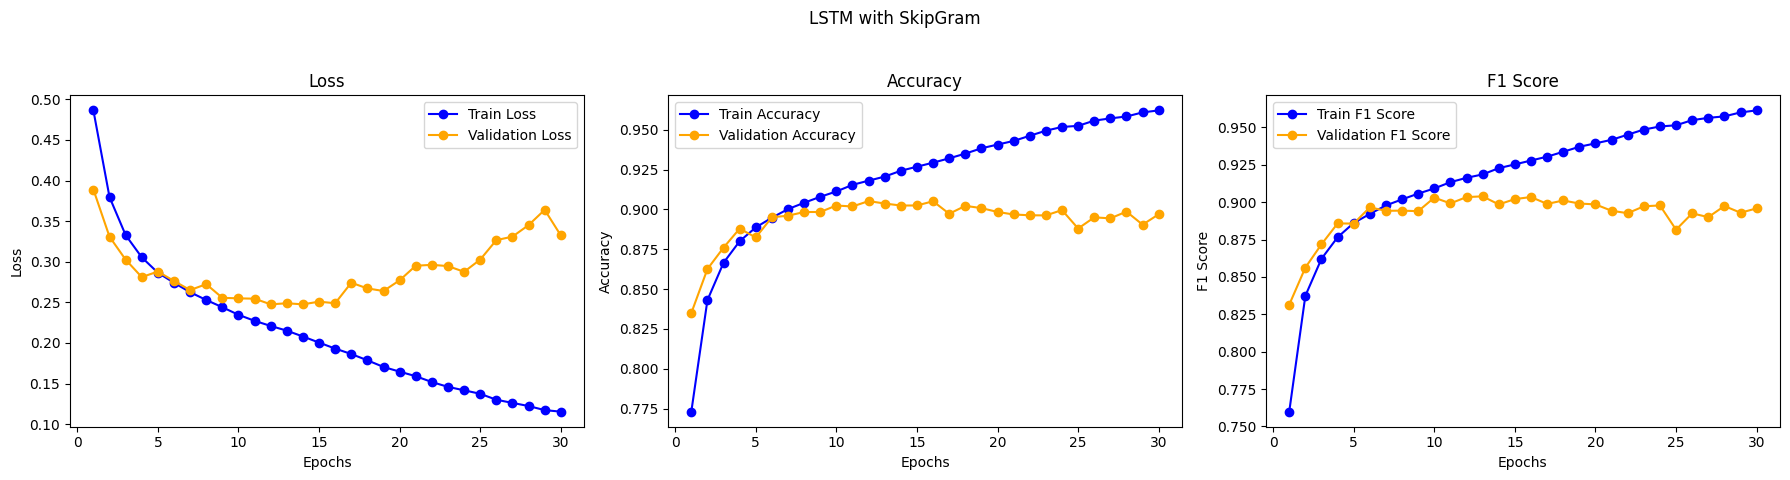

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,30,lstm_config['learning_rate'])
sketch("LSTM with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

LSTM with pretrained W2V in Gensim

Epoch [1/20], Train Loss: 0.3259, Val Loss: 0.2437, Train Accuracy: 0.8628%, Val Accuracy: 0.9035%, Train F1-Score: 0.8619%, Val F1-Score: 0.8977%
Epoch [2/20], Train Loss: 0.2192, Val Loss: 0.2121, Train Accuracy: 0.9194%, Val Accuracy: 0.9203%, Train F1-Score: 0.9178%, Val F1-Score: 0.9194%
Epoch [3/20], Train Loss: 0.1917, Val Loss: 0.1989, Train Accuracy: 0.9301%, Val Accuracy: 0.9252%, Train F1-Score: 0.9290%, Val F1-Score: 0.9239%
Epoch [4/20], Train Loss: 0.1713, Val Loss: 0.2097, Train Accuracy: 0.9380%, Val Accuracy: 0.9255%, Train F1-Score: 0.9371%, Val F1-Score: 0.9241%
Epoch [5/20], Train Loss: 0.1500, Val Loss: 0.2179, Train Accuracy: 0.9467%, Val Accuracy: 0.9263%, Train F1-Score: 0.9460%, Val F1-Score: 0.9259%
Epoch [6/20], Train Loss: 0.1290, Val Loss: 0.2149, Train Accuracy: 0.9549%, Val Accuracy: 0.9240%, Train F1-Score: 0.9543%, Val F1-Score: 0.9232%
Epoch [7/20], Train Loss: 0.1110, Val Loss: 0.2278, Train Accuracy: 0.9623%, Val Accuracy: 0.9209%, Train F1-Score: 0.

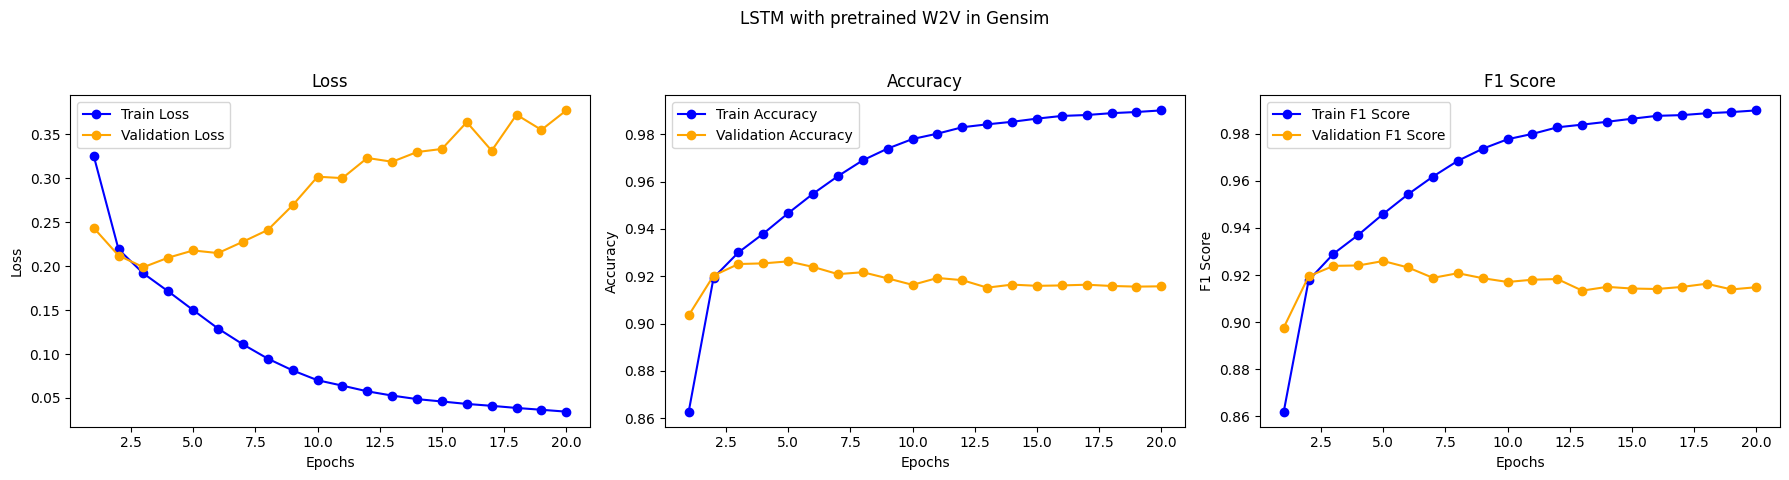

In [ ]:
model = SentimentLSTM(
    vocab_size= VOCAB_SIZE,
    embedding_dim= lstm_config["embedding_dim"],
    hidden_size=lstm_config["hidden_size"],
    tagset_size=1,
    n_layers=lstm_config["num_layers"],
    dropout_rate=lstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,20,lstm_config['learning_rate'])
sketch("LSTM with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# Bi-LSTM with Attenion Layer


BI-LSTM_Attention without preprocessing model


Epoch [1/5], Train Loss: 0.2302, Val Loss: 0.1955, Train Accuracy: 0.9116%, Val Accuracy: 0.9259%, Train F1-Score: 0.9091%, Val F1-Score: 0.9246%
Epoch [2/5], Train Loss: 0.1704, Val Loss: 0.1838, Train Accuracy: 0.9374%, Val Accuracy: 0.9305%, Train F1-Score: 0.9368%, Val F1-Score: 0.9300%
Epoch [3/5], Train Loss: 0.1377, Val Loss: 0.1996, Train Accuracy: 0.9504%, Val Accuracy: 0.9296%, Train F1-Score: 0.9497%, Val F1-Score: 0.9288%
Epoch [4/5], Train Loss: 0.1075, Val Loss: 0.2136, Train Accuracy: 0.9623%, Val Accuracy: 0.9264%, Train F1-Score: 0.9618%, Val F1-Score: 0.9263%
Epoch [5/5], Train Loss: 0.0785, Val Loss: 0.2591, Train Accuracy: 0.9727%, Val Accuracy: 0.9209%, Train F1-Score: 0.9724%, Val F1-Score: 0.9213%

Training complete!
Best Model at Epoch 2: Train Loss: 0.1704, Val Loss: 0.1838, Train Accuracy: 0.9374%, Val Accuracy: 0.9305%, Train F1-Score: 0.9368%, Val F1-Score: 0.9300%


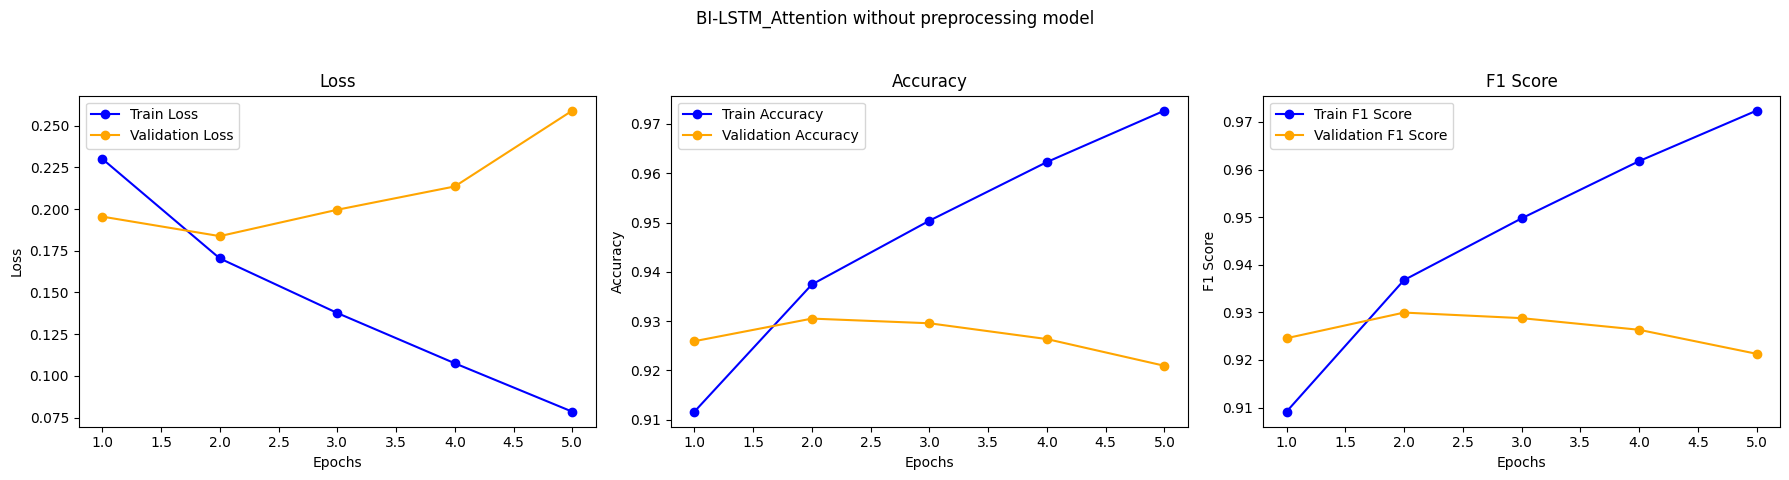

In [ ]:
model = BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,5,bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with CBOW

<ipython-input-7-5b52416406e3>:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/20], Train Loss: 0.4419, Val Loss: 0.3446, Train Accuracy: 0.8073%, Val Accuracy: 0.8584%, Train F1-Score: 0.7957%, Val F1-Score: 0.8550%
Epoch [2/20], Train Loss: 0.3237, Val Loss: 0.3030, Train Accuracy: 0.8709%, Val Accuracy: 0.8763%, Train F1-Score: 0.8668%, Val F1-Score: 0.8692%
Epoch [3/20], Train Loss: 0.3044, Val Loss: 0.2989, Train Accuracy: 0.8798%, Val Accuracy: 0.8822%, Train F1-Score: 0.8765%, Val F1-Score: 0.8831%
Epoch [4/20], Train Loss: 0.2887, Val Loss: 0.2789, Train Accuracy: 0.8875%, Val Accuracy: 0.8887%, Train F1-Score: 0.8844%, Val F1-Score: 0.8893%
Epoch [5/20], Train Loss: 0.2756, Val Loss: 0.2629, Train Accuracy: 0.8932%, Val Accuracy: 0.8968%, Train F1-Score: 0.8906%, Val F1-Score: 0.8940%
Epoch [6/20], Train Loss: 0.2627, Val Loss: 0.2788, Train Accuracy: 0.8990%, Val Accuracy: 0.8854%, Train F1-Score: 0.8966%, Val F1-Score: 0.8904%
Epoch [7/20], Train Loss: 0.2555, Val Loss: 0.2508, Train Accuracy: 0.9027%, Val Accuracy: 0.9041%, Train F1-Score: 0.

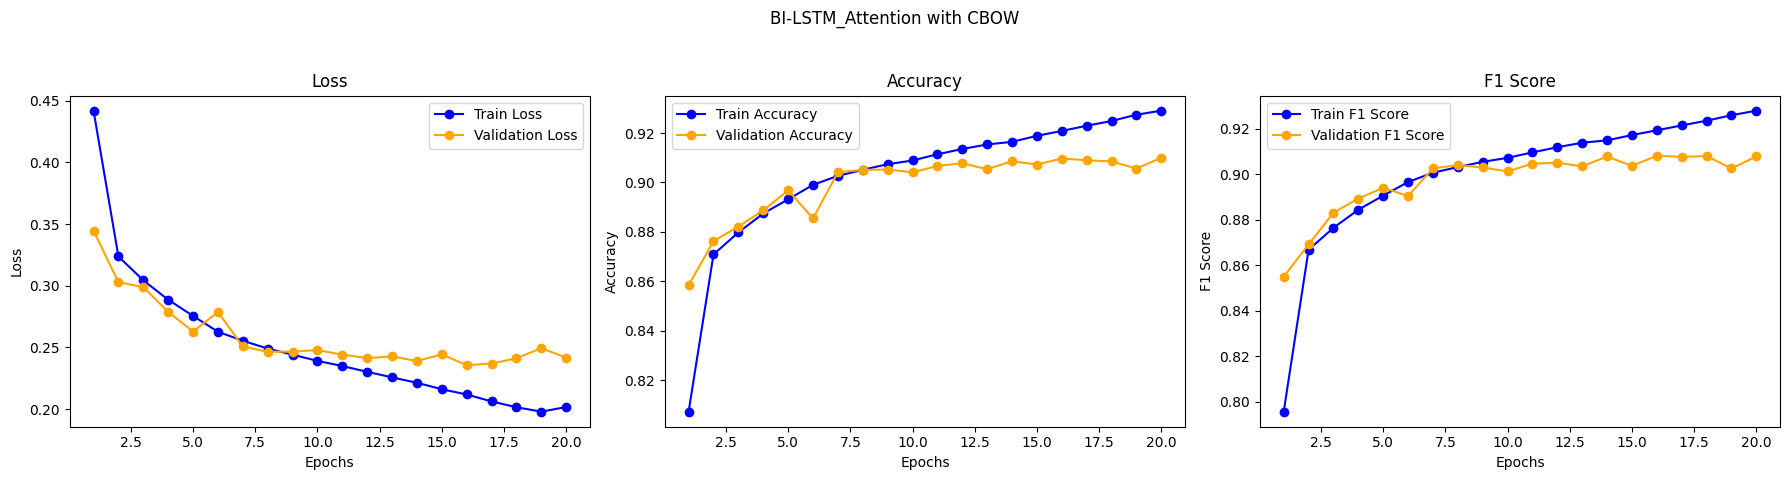

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config["epochs"],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with SKipGram

<ipython-input-1-5b52416406e3>:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/20], Train Loss: 0.3818, Val Loss: 0.3085, Train Accuracy: 0.8395%, Val Accuracy: 0.8756%, Train F1-Score: 0.8312%, Val F1-Score: 0.8717%
Epoch [2/20], Train Loss: 0.3078, Val Loss: 0.2864, Train Accuracy: 0.8782%, Val Accuracy: 0.8851%, Train F1-Score: 0.8745%, Val F1-Score: 0.8812%
Epoch [3/20], Train Loss: 0.2829, Val Loss: 0.2681, Train Accuracy: 0.8896%, Val Accuracy: 0.8952%, Train F1-Score: 0.8865%, Val F1-Score: 0.8934%
Epoch [4/20], Train Loss: 0.2672, Val Loss: 0.2686, Train Accuracy: 0.8967%, Val Accuracy: 0.8936%, Train F1-Score: 0.8940%, Val F1-Score: 0.8912%
Epoch [5/20], Train Loss: 0.2532, Val Loss: 0.2574, Train Accuracy: 0.9029%, Val Accuracy: 0.9001%, Train F1-Score: 0.9007%, Val F1-Score: 0.8965%
Epoch [6/20], Train Loss: 0.2421, Val Loss: 0.2551, Train Accuracy: 0.9072%, Val Accuracy: 0.9014%, Train F1-Score: 0.9050%, Val F1-Score: 0.8974%
Epoch [7/20], Train Loss: 0.2318, Val Loss: 0.2532, Train Accuracy: 0.9124%, Val Accuracy: 0.9031%, Train F1-Score: 0.

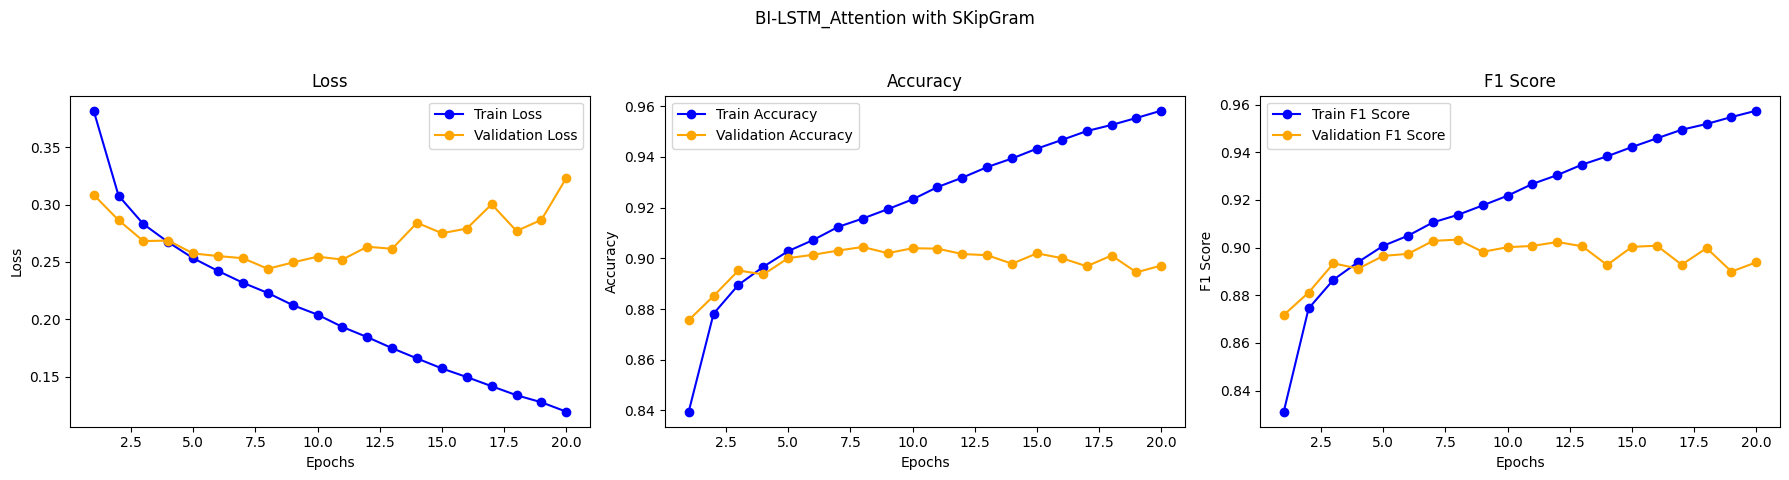

In [ ]:
model = BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,bilstm_config["epochs"],bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

BI-LSTM_Attention with pretrained W2V in Gensim

Epoch [1/5], Train Loss: 0.2568, Val Loss: 0.2141, Train Accuracy: 0.9021%, Val Accuracy: 0.9202%, Train F1-Score: 0.9000%, Val F1-Score: 0.9179%
Epoch [2/5], Train Loss: 0.1983, Val Loss: 0.1974, Train Accuracy: 0.9269%, Val Accuracy: 0.9247%, Train F1-Score: 0.9257%, Val F1-Score: 0.9246%
Epoch [3/5], Train Loss: 0.1694, Val Loss: 0.1938, Train Accuracy: 0.9387%, Val Accuracy: 0.9264%, Train F1-Score: 0.9376%, Val F1-Score: 0.9263%
Epoch [4/5], Train Loss: 0.1415, Val Loss: 0.2091, Train Accuracy: 0.9499%, Val Accuracy: 0.9252%, Train F1-Score: 0.9493%, Val F1-Score: 0.9235%
Epoch [5/5], Train Loss: 0.1137, Val Loss: 0.2260, Train Accuracy: 0.9604%, Val Accuracy: 0.9262%, Train F1-Score: 0.9599%, Val F1-Score: 0.9260%

Training complete!
Best Model at Epoch 3: Train Loss: 0.1694, Val Loss: 0.1938, Train Accuracy: 0.9387%, Val Accuracy: 0.9264%, Train F1-Score: 0.9376%, Val F1-Score: 0.9263%


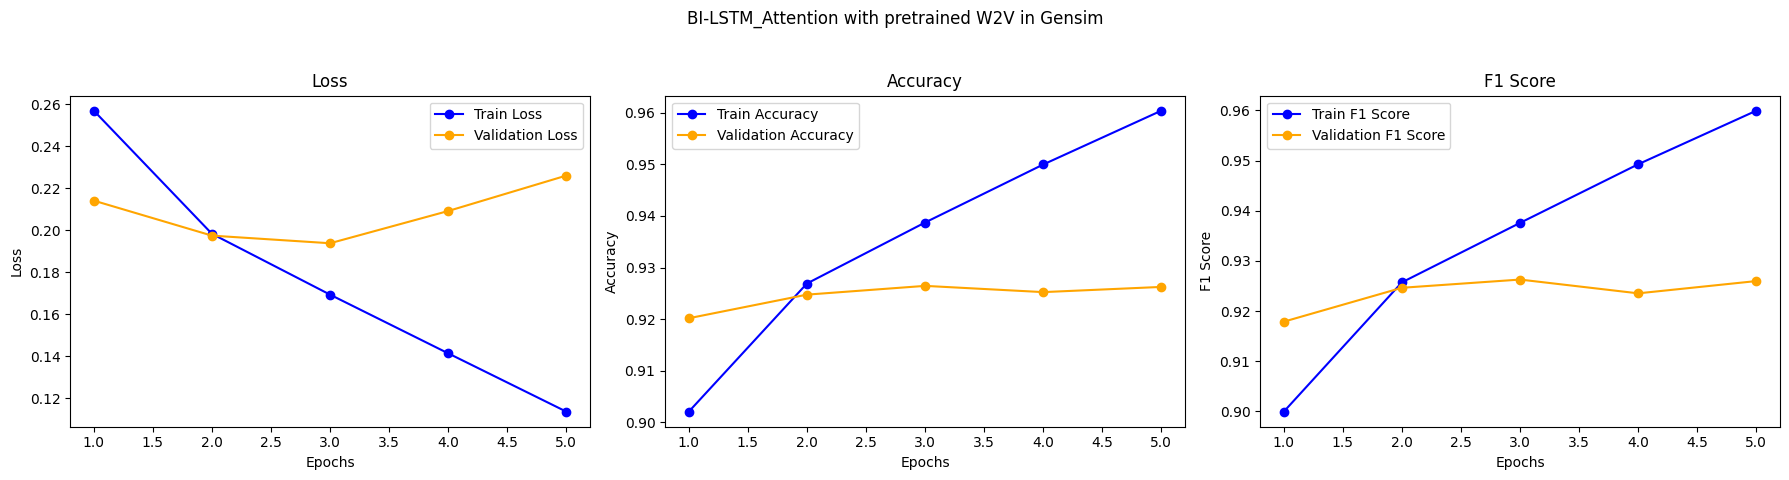

In [ ]:
model =BiLSTM_Attention(
    vocab_size= VOCAB_SIZE,
    embedding_dim= bilstm_config["embedding_dim"],
    hidden_size=bilstm_config["hidden_size"],
    tagset_size=1,
    n_layers=bilstm_config["num_layers"],
    dropout_rate=bilstm_config['dropout_rate'],
    pretrained_embeddings=embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,5,bilstm_config['learning_rate'])
sketch("BI-LSTM_Attention with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# GRU

GRU without preprocessing model

Epoch [1/5], Train Loss: 0.2321, Val Loss: 0.1933, Train Accuracy: 0.9098%, Val Accuracy: 0.9280%, Train F1-Score: 0.9071%, Val F1-Score: 0.9284%
Epoch [2/5], Train Loss: 0.1662, Val Loss: 0.1838, Train Accuracy: 0.9377%, Val Accuracy: 0.9317%, Train F1-Score: 0.9368%, Val F1-Score: 0.9305%
Epoch [3/5], Train Loss: 0.1340, Val Loss: 0.1960, Train Accuracy: 0.9508%, Val Accuracy: 0.9305%, Train F1-Score: 0.9503%, Val F1-Score: 0.9301%
Epoch [4/5], Train Loss: 0.1044, Val Loss: 0.2063, Train Accuracy: 0.9628%, Val Accuracy: 0.9288%, Train F1-Score: 0.9623%, Val F1-Score: 0.9287%
Epoch [5/5], Train Loss: 0.0813, Val Loss: 0.2502, Train Accuracy: 0.9718%, Val Accuracy: 0.9258%, Train F1-Score: 0.9715%, Val F1-Score: 0.9260%

Training complete!
Best Model at Epoch 2: Train Loss: 0.1662, Val Loss: 0.1838, Train Accuracy: 0.9377%, Val Accuracy: 0.9317%, Train F1-Score: 0.9368%, Val F1-Score: 0.9305%


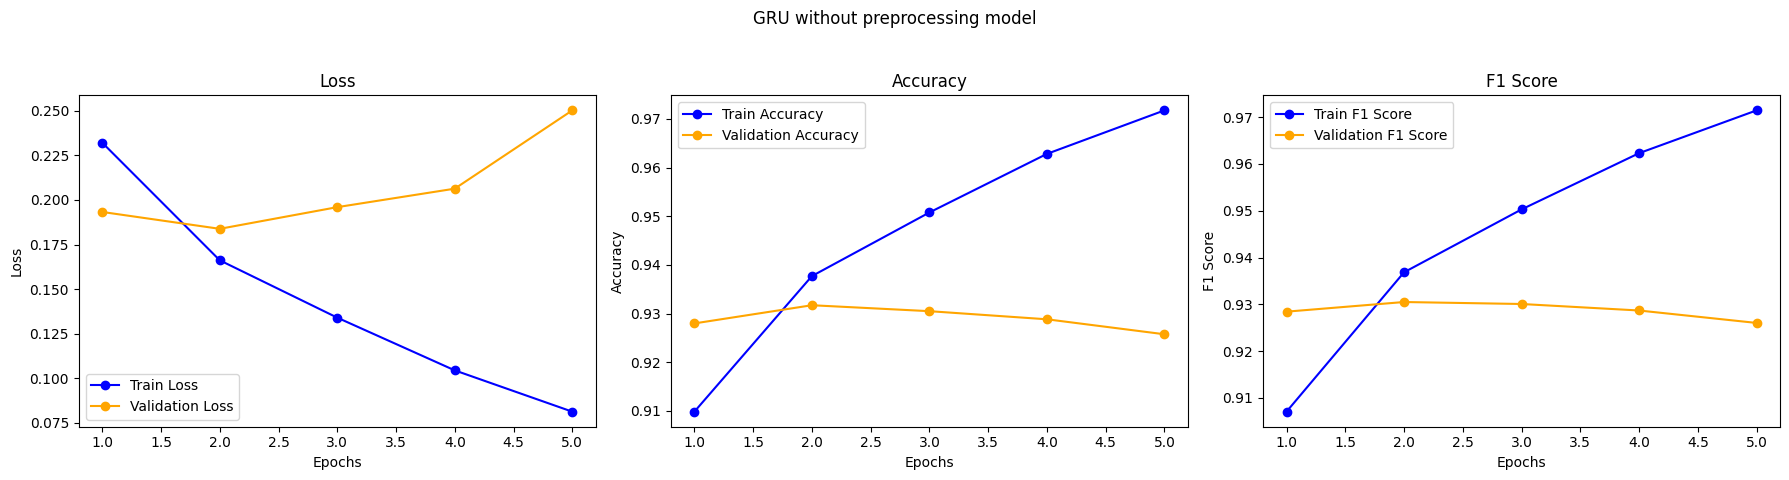

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate']
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,5,gru_config['learning_rate'])
sketch("GRU without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with CBOW

<ipython-input-19-76ae736803f5>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/30], Train Loss: 0.4421, Val Loss: 0.3380, Train Accuracy: 0.8036%, Val Accuracy: 0.8621%, Train F1-Score: 0.7926%, Val F1-Score: 0.8546%
Epoch [2/30], Train Loss: 0.3148, Val Loss: 0.2998, Train Accuracy: 0.8731%, Val Accuracy: 0.8784%, Train F1-Score: 0.8695%, Val F1-Score: 0.8705%
Epoch [3/30], Train Loss: 0.2920, Val Loss: 0.2840, Train Accuracy: 0.8840%, Val Accuracy: 0.8893%, Train F1-Score: 0.8807%, Val F1-Score: 0.8846%
Epoch [4/30], Train Loss: 0.2752, Val Loss: 0.3150, Train Accuracy: 0.8913%, Val Accuracy: 0.8758%, Train F1-Score: 0.8882%, Val F1-Score: 0.8638%
Epoch [5/30], Train Loss: 0.2611, Val Loss: 0.2530, Train Accuracy: 0.8977%, Val Accuracy: 0.9000%, Train F1-Score: 0.8952%, Val F1-Score: 0.8989%
Epoch [6/30], Train Loss: 0.2498, Val Loss: 0.2505, Train Accuracy: 0.9026%, Val Accuracy: 0.9032%, Train F1-Score: 0.9003%, Val F1-Score: 0.8996%
Epoch [7/30], Train Loss: 0.2396, Val Loss: 0.2438, Train Accuracy: 0.9072%, Val Accuracy: 0.9065%, Train F1-Score: 0.

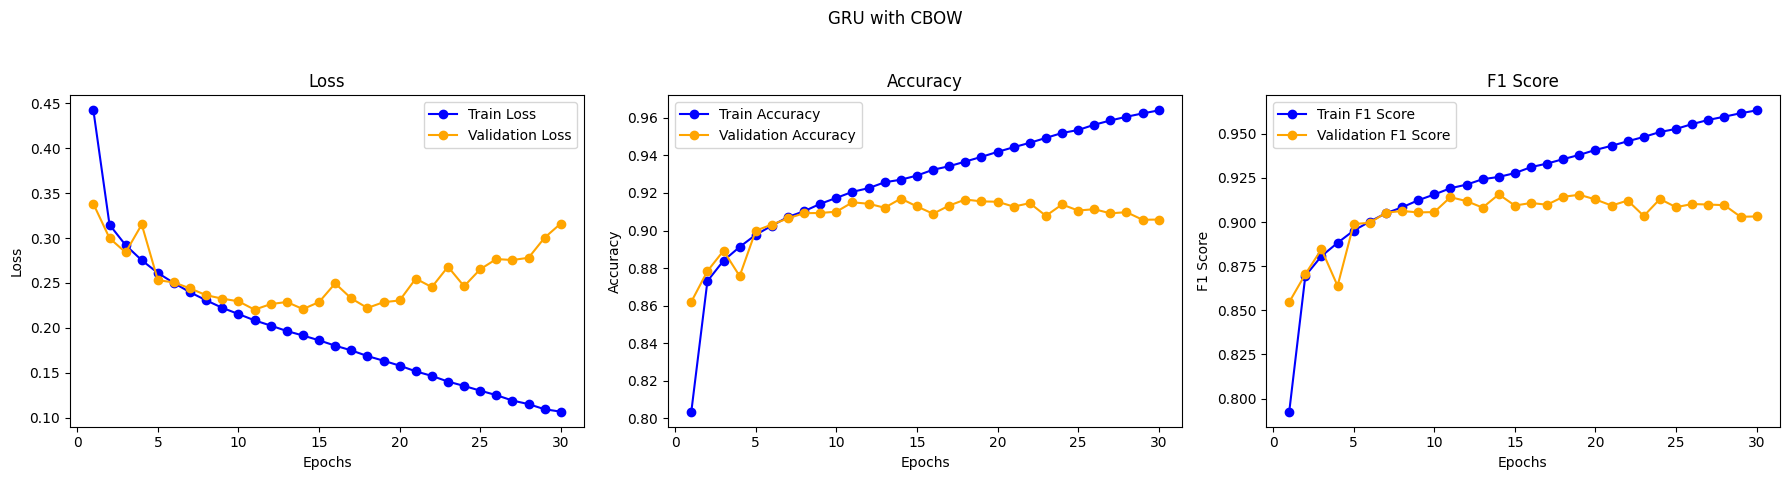

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with SKipGram

<ipython-input-1-76ae736803f5>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pretrained_embeddings = torch.tensor(pretrained_embeddings, dtype=torch.float32)


Epoch [1/30], Train Loss: 0.3955, Val Loss: 0.3356, Train Accuracy: 0.8276%, Val Accuracy: 0.8592%, Train F1-Score: 0.8168%, Val F1-Score: 0.8491%
Epoch [2/30], Train Loss: 0.3091, Val Loss: 0.2878, Train Accuracy: 0.8726%, Val Accuracy: 0.8843%, Train F1-Score: 0.8690%, Val F1-Score: 0.8822%
Epoch [3/30], Train Loss: 0.2817, Val Loss: 0.2763, Train Accuracy: 0.8860%, Val Accuracy: 0.8889%, Train F1-Score: 0.8829%, Val F1-Score: 0.8828%
Epoch [4/30], Train Loss: 0.2606, Val Loss: 0.2713, Train Accuracy: 0.8957%, Val Accuracy: 0.8946%, Train F1-Score: 0.8933%, Val F1-Score: 0.8907%
Epoch [5/30], Train Loss: 0.2482, Val Loss: 0.2600, Train Accuracy: 0.9018%, Val Accuracy: 0.8959%, Train F1-Score: 0.8993%, Val F1-Score: 0.8937%
Epoch [6/30], Train Loss: 0.2373, Val Loss: 0.2705, Train Accuracy: 0.9071%, Val Accuracy: 0.9001%, Train F1-Score: 0.9051%, Val F1-Score: 0.8957%
Epoch [7/30], Train Loss: 0.2272, Val Loss: 0.2559, Train Accuracy: 0.9109%, Val Accuracy: 0.9018%, Train F1-Score: 0.

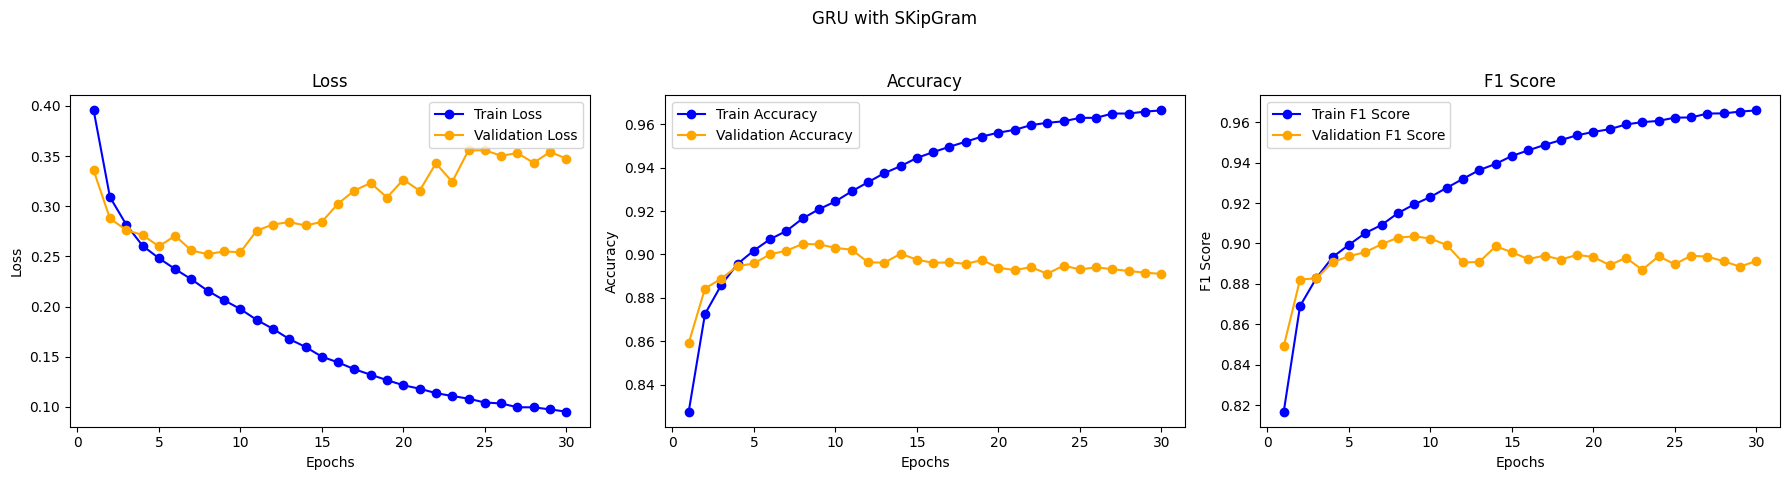

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,gru_config['epochs'],gru_config['learning_rate'])
sketch("GRU with SKipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

GRU with pretrained W2V in Gensim

Epoch [1/5], Train Loss: 0.2599, Val Loss: 0.2044, Train Accuracy: 0.8976%, Val Accuracy: 0.9218%, Train F1-Score: 0.8931%, Val F1-Score: 0.9205%
Epoch [2/5], Train Loss: 0.1903, Val Loss: 0.1910, Train Accuracy: 0.9280%, Val Accuracy: 0.9280%, Train F1-Score: 0.9269%, Val F1-Score: 0.9276%
Epoch [3/5], Train Loss: 0.1629, Val Loss: 0.1910, Train Accuracy: 0.9394%, Val Accuracy: 0.9280%, Train F1-Score: 0.9383%, Val F1-Score: 0.9274%
Epoch [4/5], Train Loss: 0.1358, Val Loss: 0.1999, Train Accuracy: 0.9506%, Val Accuracy: 0.9252%, Train F1-Score: 0.9498%, Val F1-Score: 0.9259%
Epoch [5/5], Train Loss: 0.1102, Val Loss: 0.2149, Train Accuracy: 0.9612%, Val Accuracy: 0.9245%, Train F1-Score: 0.9604%, Val F1-Score: 0.9243%

Training complete!
Best Model at Epoch 2: Train Loss: 0.1903, Val Loss: 0.1910, Train Accuracy: 0.9280%, Val Accuracy: 0.9280%, Train F1-Score: 0.9269%, Val F1-Score: 0.9276%


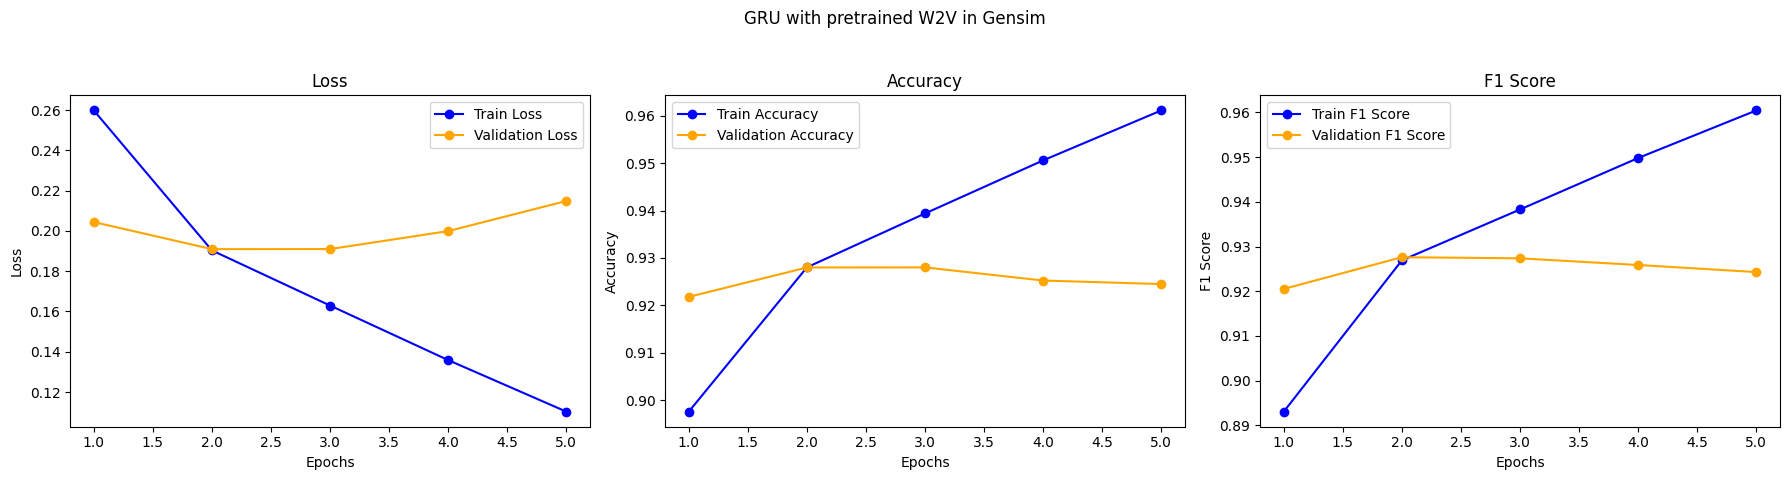

In [ ]:
model =GRU(
    vocab_size= VOCAB_SIZE,
    embedding_dim= gru_config["embedding_dim"],
    hidden_size=gru_config["hidden_size"],
    tagset_size=1,
    n_layers=gru_config["num_layers"],
    dropout_rate=gru_config['dropout_rate'],
    pretrained_embeddings= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,5,gru_config['learning_rate'])
sketch("GRU with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

# CNN

CNN without preprocessing model

Epoch [1/15], Train Loss: 0.3157, Val Loss: 0.2338, Train Accuracy: 0.8684%, Val Accuracy: 0.9087%, Train F1-Score: 0.8656%, Val F1-Score: 0.9061%
Epoch [2/15], Train Loss: 0.2355, Val Loss: 0.2125, Train Accuracy: 0.9083%, Val Accuracy: 0.9192%, Train F1-Score: 0.9064%, Val F1-Score: 0.9176%
Epoch [3/15], Train Loss: 0.2098, Val Loss: 0.2038, Train Accuracy: 0.9192%, Val Accuracy: 0.9227%, Train F1-Score: 0.9175%, Val F1-Score: 0.9217%
Epoch [4/15], Train Loss: 0.1926, Val Loss: 0.1987, Train Accuracy: 0.9264%, Val Accuracy: 0.9245%, Train F1-Score: 0.9250%, Val F1-Score: 0.9232%
Epoch [5/15], Train Loss: 0.1793, Val Loss: 0.1958, Train Accuracy: 0.9323%, Val Accuracy: 0.9256%, Train F1-Score: 0.9311%, Val F1-Score: 0.9248%
Epoch [6/15], Train Loss: 0.1676, Val Loss: 0.1948, Train Accuracy: 0.9371%, Val Accuracy: 0.9275%, Train F1-Score: 0.9357%, Val F1-Score: 0.9270%
Epoch [7/15], Train Loss: 0.1556, Val Loss: 0.1929, Train Accuracy: 0.9413%, Val Accuracy: 0.9281%, Train F1-Score: 0.

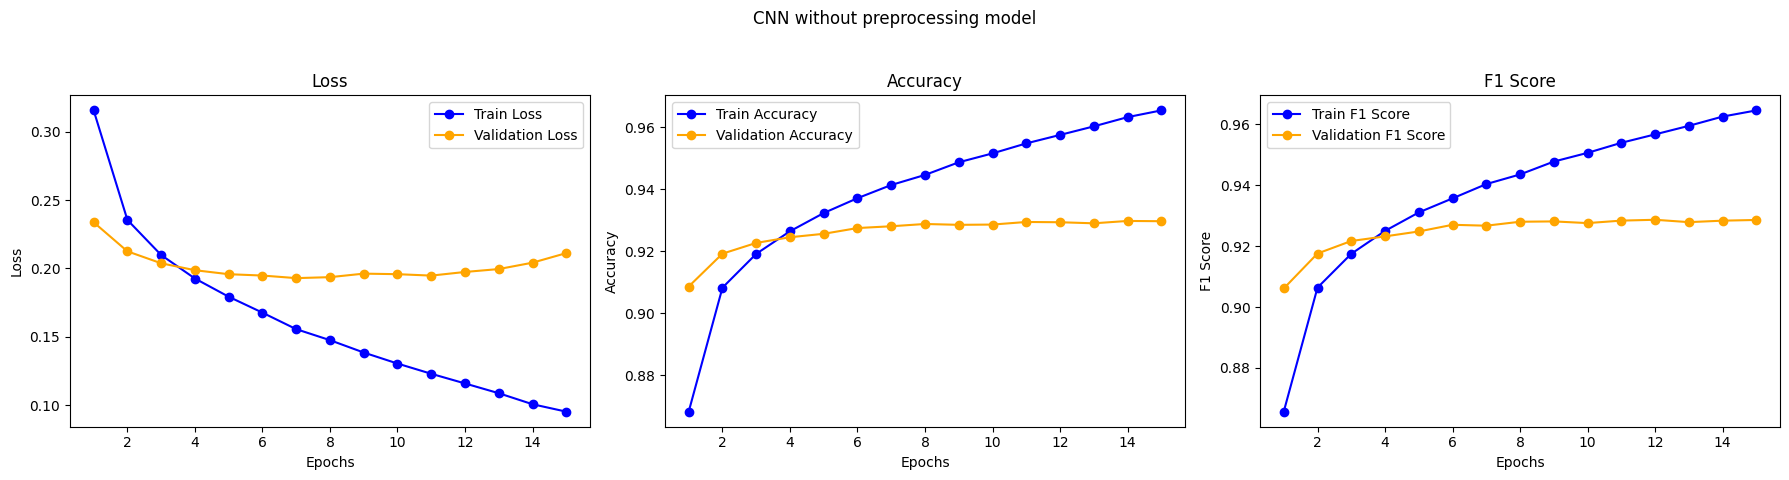

In [ ]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN without preprocessing model",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with CBOW

Epoch [1/15], Train Loss: 0.3234, Val Loss: 0.2129, Train Accuracy: 0.8619%, Val Accuracy: 0.9187%, Train F1-Score: 0.8626%, Val F1-Score: 0.9174%
Epoch [2/15], Train Loss: 0.2056, Val Loss: 0.1961, Train Accuracy: 0.9215%, Val Accuracy: 0.9254%, Train F1-Score: 0.9204%, Val F1-Score: 0.9249%
Epoch [3/15], Train Loss: 0.1889, Val Loss: 0.1918, Train Accuracy: 0.9285%, Val Accuracy: 0.9267%, Train F1-Score: 0.9275%, Val F1-Score: 0.9261%
Epoch [4/15], Train Loss: 0.1782, Val Loss: 0.1888, Train Accuracy: 0.9335%, Val Accuracy: 0.9280%, Train F1-Score: 0.9323%, Val F1-Score: 0.9271%
Epoch [5/15], Train Loss: 0.1691, Val Loss: 0.1883, Train Accuracy: 0.9367%, Val Accuracy: 0.9284%, Train F1-Score: 0.9355%, Val F1-Score: 0.9273%
Epoch [6/15], Train Loss: 0.1619, Val Loss: 0.1910, Train Accuracy: 0.9397%, Val Accuracy: 0.9269%, Train F1-Score: 0.9387%, Val F1-Score: 0.9267%
Epoch [7/15], Train Loss: 0.1545, Val Loss: 0.1916, Train Accuracy: 0.9427%, Val Accuracy: 0.9269%, Train F1-Score: 0.

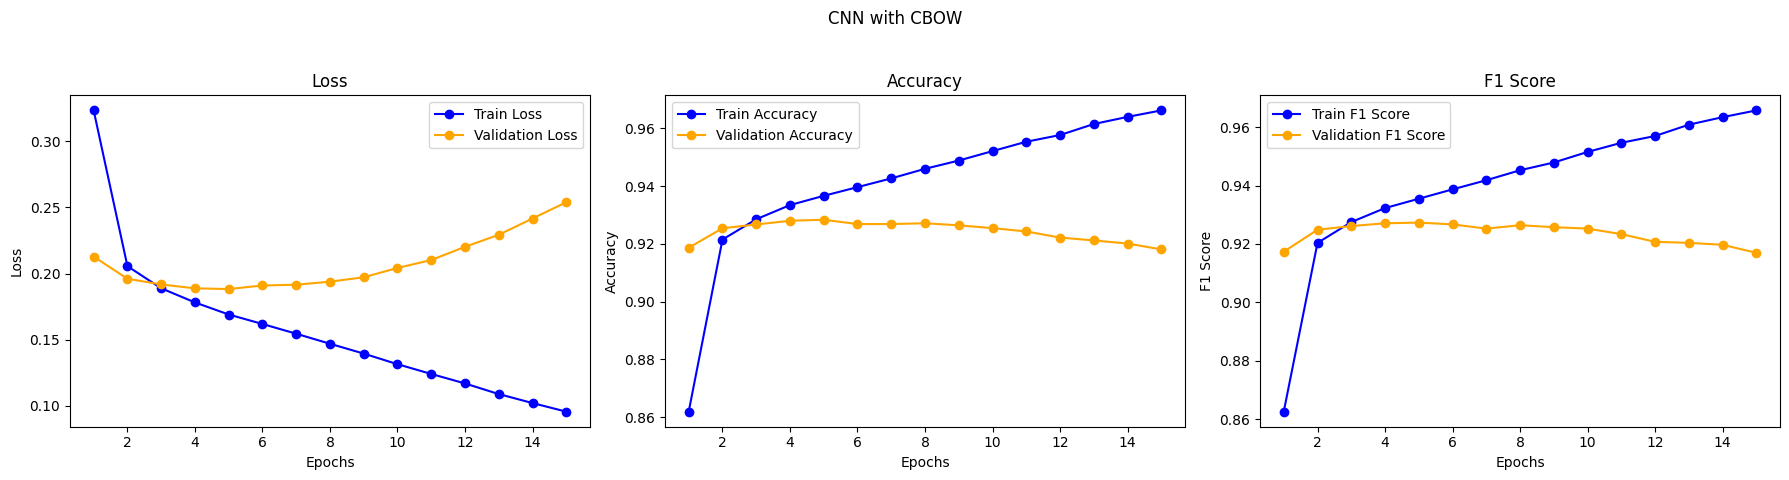

In [ ]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= cbow_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with CBOW",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with SkipGram

Epoch [1/15], Train Loss: 0.3332, Val Loss: 0.2261, Train Accuracy: 0.8613%, Val Accuracy: 0.9133%, Train F1-Score: 0.8584%, Val F1-Score: 0.9137%
Epoch [2/15], Train Loss: 0.2126, Val Loss: 0.2010, Train Accuracy: 0.9196%, Val Accuracy: 0.9235%, Train F1-Score: 0.9183%, Val F1-Score: 0.9233%
Epoch [3/15], Train Loss: 0.1927, Val Loss: 0.1911, Train Accuracy: 0.9273%, Val Accuracy: 0.9272%, Train F1-Score: 0.9261%, Val F1-Score: 0.9265%
Epoch [4/15], Train Loss: 0.1818, Val Loss: 0.1905, Train Accuracy: 0.9321%, Val Accuracy: 0.9271%, Train F1-Score: 0.9310%, Val F1-Score: 0.9270%
Epoch [5/15], Train Loss: 0.1732, Val Loss: 0.1870, Train Accuracy: 0.9355%, Val Accuracy: 0.9288%, Train F1-Score: 0.9344%, Val F1-Score: 0.9280%
Epoch [6/15], Train Loss: 0.1658, Val Loss: 0.1867, Train Accuracy: 0.9385%, Val Accuracy: 0.9288%, Train F1-Score: 0.9375%, Val F1-Score: 0.9274%
Epoch [7/15], Train Loss: 0.1600, Val Loss: 0.1866, Train Accuracy: 0.9406%, Val Accuracy: 0.9296%, Train F1-Score: 0.

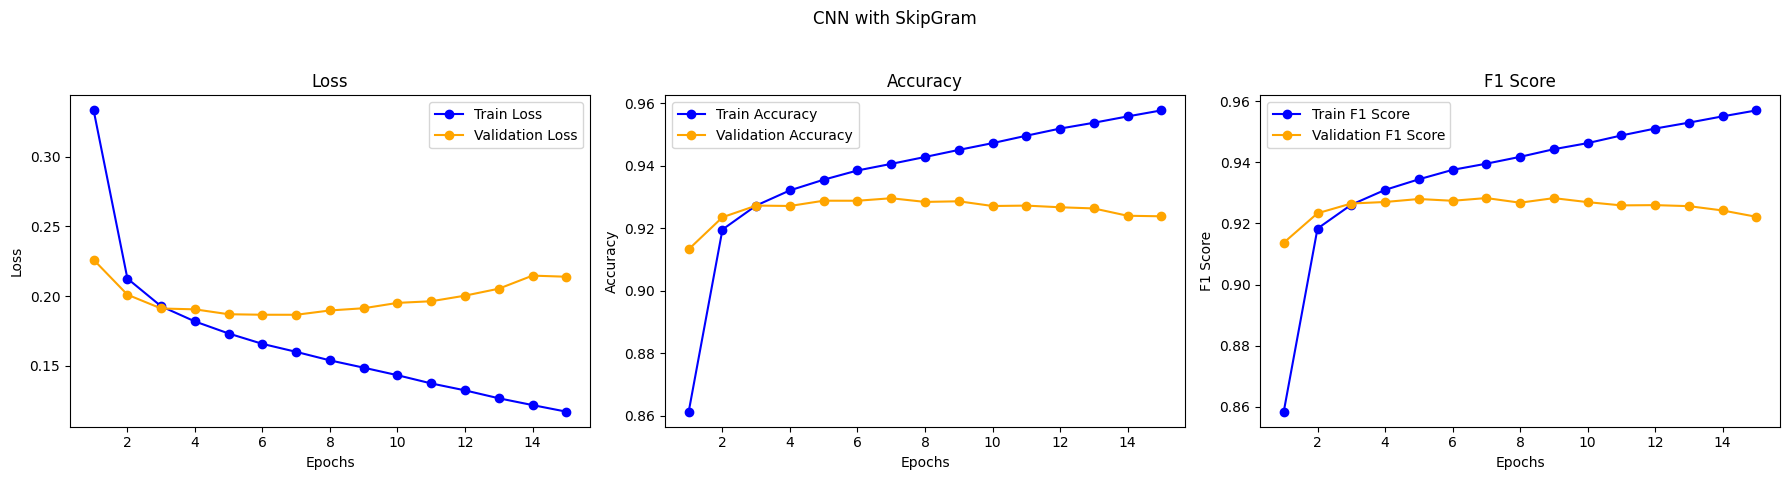

In [ ]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= sg_embeddings
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with SkipGram",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)

CNN with pretrained W2V in Gensim

Epoch [1/15], Train Loss: 0.3120, Val Loss: 0.2280, Train Accuracy: 0.8701%, Val Accuracy: 0.9123%, Train F1-Score: 0.8706%, Val F1-Score: 0.9104%
Epoch [2/15], Train Loss: 0.2243, Val Loss: 0.2079, Train Accuracy: 0.9138%, Val Accuracy: 0.9200%, Train F1-Score: 0.9120%, Val F1-Score: 0.9195%
Epoch [3/15], Train Loss: 0.1986, Val Loss: 0.1967, Train Accuracy: 0.9244%, Val Accuracy: 0.9246%, Train F1-Score: 0.9231%, Val F1-Score: 0.9227%
Epoch [4/15], Train Loss: 0.1804, Val Loss: 0.1923, Train Accuracy: 0.9315%, Val Accuracy: 0.9273%, Train F1-Score: 0.9304%, Val F1-Score: 0.9259%
Epoch [5/15], Train Loss: 0.1659, Val Loss: 0.1891, Train Accuracy: 0.9378%, Val Accuracy: 0.9285%, Train F1-Score: 0.9367%, Val F1-Score: 0.9272%
Epoch [6/15], Train Loss: 0.1548, Val Loss: 0.1889, Train Accuracy: 0.9418%, Val Accuracy: 0.9288%, Train F1-Score: 0.9408%, Val F1-Score: 0.9274%
Epoch [7/15], Train Loss: 0.1435, Val Loss: 0.1899, Train Accuracy: 0.9470%, Val Accuracy: 0.9294%, Train F1-Score: 0.

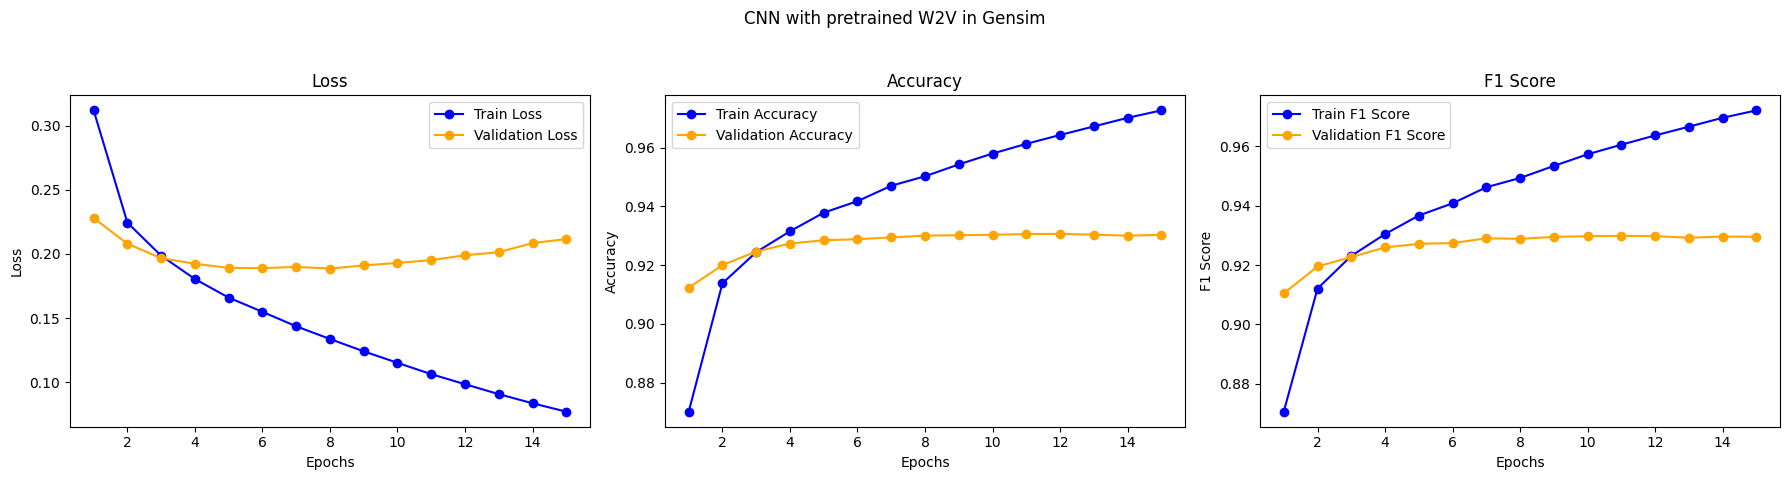

In [ ]:
model =CNN(
    vocab_size= VOCAB_SIZE,
    embedding_dim= cnn_config["embedding_dim"],
    num_filters= cnn_config["num_filters"],
    filter_sizes= cnn_config["filter_sizes"],
    dropout= cnn_config["dropout_rate"],
    embedding_matrix= embedding_matrix
).to(device)
train_losses,val_losses,train_accs,val_accs, train_f1, val_f1 = train(model, train_loader,val_loader,cnn_config['epochs'],cnn_config['learning_rate'])
sketch("CNN with pretrained W2V in Gensim",train_losses,val_losses,train_accs,val_accs, train_f1, val_f1)